# Balls and Strikes Effects

## 6.2 Hitter’s Counts and Pitcher’s Counts

### 6.2.1 An example for a single pitcher

Analyzing Mike Mussina's career performance splits by count. The tOPS+ metric compares a player's OPS in each count situation to their overall OPS (100 = average, >100 = better than average, <100 = worse than average).

In [13]:
import pandas as pd
import numpy as np

balls = np.repeat([0, 1, 2, 3], 3)
strikes = np.tile([0, 1, 2], 4)

mussina = pd.DataFrame({
    'balls': balls,
    'strikes': strikes,
    'value': [
        100, 72, 30, 118, 82, 38,
        157, 114, 64, 207, 171, 122
    ]
})
mussina

,balls,strikes,value
0,0,0,100
1,0,1,72
2,0,2,30
3,1,0,118
4,1,1,82
5,1,2,38
6,2,0,157
7,2,1,114
8,2,2,64
9,3,0,207


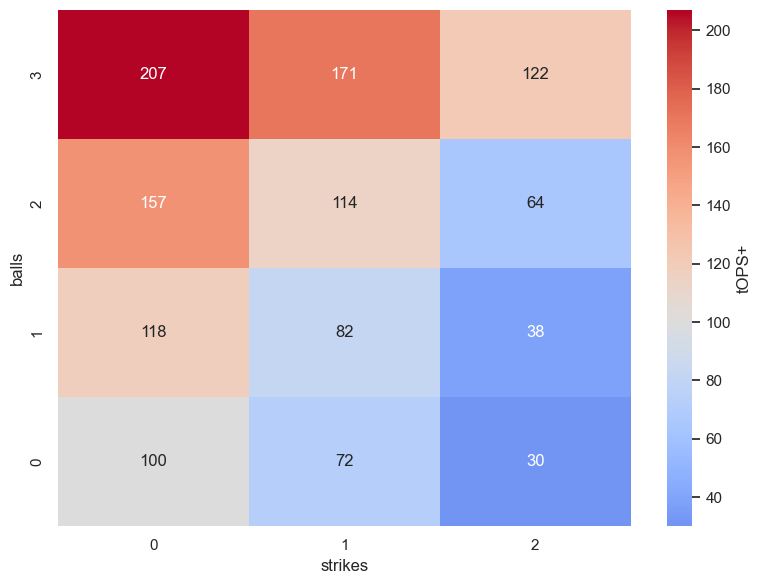

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid', palette='deep')

fig, ax = plt.subplots(figsize=(8, 6))

# Create pivot table for heatmap
pivot_data = mussina.pivot(index='balls', columns='strikes', values='value')

sns.heatmap(
    pivot_data,
    annot=True,
    fmt='g',
    cmap='coolwarm',
    center=100,
    cbar_kws={'label': 'tOPS+'},
    ax=ax
)

ax.invert_yaxis()

# Labels
ax.set_xlabel('strikes')
ax.set_ylabel('balls')

plt.tight_layout()
plt.show()


**Count Categories:**
- **Pitcher's counts** (0-2, 1-2, 0-1): Batters perform poorly (tOPS+ well below 100)
- **Hitter's counts** (3-0, 3-1, 2-0): Batters dominate (tOPS+ significantly above 100)
- **Neutral counts** (0-0, 1-1): Performance near average

The heatmap shows batters facing Mussina performed over 2x better in 3-0 counts (207) compared to 0-2 counts (30).

### 6.2.2 Pitch sequences from Retrosheet

Retrosheet encodes each pitch in a plate appearance as a character string. For example "FBSX" means:
- F = Foul ball
- B = Ball
- S = Called strike
- X = Ball in play

Need to clean and analyze sequences to determine which plate appearances passed through specific counts.

In [15]:
# Load Retrosheet 2016 data
fields = pd.read_csv('../data/fields.csv')
headers = fields['Header'].str.lower().tolist()

retro2016 = pd.read_csv('../data/all2016.csv', names=headers, low_memory=False)

# Look at pitch sequences
retro2016[['pitch_seq_tx']].head(10)

,pitch_seq_tx
0,BX
1,X
2,SFS
3,BCX
4,BSS*B1S
5,BBX
6,BCX
7,CX
8,BCCS
9,SBFX


#### String manipulation for pitch sequences

To analyze counts:
1. Remove non-pitch characters (ex: pickoff attempts, pitchouts, etc)
2. Count balls (B) and strikes (S, C, F, etc) to determine the count
3. Identify which plate appearances passed through specific counts

In [16]:
# Get pitch sequences
sequences = retro2016['pitch_seq_tx'].fillna('')

# Remove non-pitch characters using regex
cleaned = sequences.str.replace(r'[.>123N+*]', '', regex=True)

# comparison between sequences df and cleaned df
example_df = pd.DataFrame({
    'original': sequences.head(10),
    'cleaned': cleaned.head(10),
    'length': cleaned.head(10).str.len()
})
example_df

,original,cleaned,length
0,BX,BX,2
1,X,X,1
2,SFS,SFS,3
3,BCX,BCX,3
4,BSS*B1S,BSSBS,5
5,BBX,BBX,3
6,BCX,BCX,3
7,CX,CX,2
8,BCCS,BCCS,4
9,SBFX,SBFX,4


#### 6.2.2.1 Functions for string manipulation

In [17]:
len("BBSBFFFX")

8

Using `str.contains()` and `np.where()` functions to search for patterns

In [24]:
sequences = pd.Series(["BBX", "C11BBC1S", "1X"])
sequences

0         BBX
1    C11BBC1S
2          1X
dtype: object

Finding and replacing indices with patterns

In [ ]:
# Slightly different compared to R Book output as Python is 0 based index and R is 1 based
np.where(sequences.str.contains("1"))[0]

array([1, 2])

In [26]:
sequences.str.contains("1")

0    False
1     True
2     True
dtype: bool

In [27]:
sequences.str.contains("11")

0    False
1     True
2    False
dtype: bool

In [28]:
# remove pickoff attempts from sequences
sequences.str.replace("1", "", regex=False)

0      BBX
1    CBBCS
2        X
dtype: object

#### 6.2.2.2 Finding plate appearances going through a given count

In [29]:
fields = pd.read_csv('../data/fields.csv')
headers = fields['Header'].str.lower().tolist()

retro2016 = pd.read_csv('../data/all2016.csv', names=headers, low_memory=False)

In [30]:
# Remove non-pitch characters from pitch sequences
pbp2016 = retro2016.copy()
pbp2016['pseq'] = pbp2016['pitch_seq_tx'].str.replace(r'[.>123N+*]', '', regex=True)

In [31]:
# Detect 1-0 counts
pbp2016['c10'] = pbp2016['pseq'].str.match(r'^[BIPV]')

In [32]:
# Detect 0-1 counts
pbp2016['c01'] = pbp2016['pseq'].str.match(r'^[CFKLMOQRST]')

In [ ]:
pbp2016[['pitch_seq_tx', 'c10', 'c01']].head(10)

,pitch_seq_tx,c10,c01
0,BX,True,False
1,X,False,False
2,SFS,False,True
3,BCX,True,False
4,BSS*B1S,True,False
5,BBX,True,False
6,BCX,True,False
7,CX,False,True
8,BCCS,True,False
9,SBFX,False,True
